This program Analysis and predicts the emission of Nitrogen oxides of a Gas Turbine. The prediction is perfomed using Gas Turbine data Varibles given below.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [9]:
data=pd.read_csv('gt_full.csv')

# Gas Turbine Data Variables

# Initial Data Exploration

In [10]:
data.head(10)

,Unnamed: 0,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,2,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,4,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,5,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028
5,6,3.8858,1017.7,83.946,3.5824,23.903,1086.0,549.98,134.67,11.868,0.23473,81.748
6,7,3.6697,1018.0,84.114,3.5804,23.889,1085.9,550.04,134.68,11.877,0.44412,84.592
7,8,3.5892,1018.2,83.867,3.5777,23.876,1086.0,549.88,134.66,11.893,0.79996,84.193
8,9,3.7108,1018.5,84.948,3.6027,23.957,1086.3,549.98,134.65,11.870,0.68996,83.978
9,10,4.8281,1018.5,85.346,3.5158,23.422,1083.1,549.80,132.67,11.694,1.02810,82.654


In [12]:
data_ref=data.drop('Unnamed: 0',axis=1)
data_ref.head(10)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028
5,3.8858,1017.7,83.946,3.5824,23.903,1086.0,549.98,134.67,11.868,0.23473,81.748
6,3.6697,1018.0,84.114,3.5804,23.889,1085.9,550.04,134.68,11.877,0.44412,84.592
7,3.5892,1018.2,83.867,3.5777,23.876,1086.0,549.88,134.66,11.893,0.79996,84.193
8,3.7108,1018.5,84.948,3.6027,23.957,1086.3,549.98,134.65,11.870,0.68996,83.978
9,4.8281,1018.5,85.346,3.5158,23.422,1083.1,549.80,132.67,11.694,1.02810,82.654


In [13]:
data_ref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


In [16]:
print('Columns in the Dataset:')
cols=data_ref.columns
cols

Columns in the Dataset:


Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

In [18]:
print('Dataset Statistical Description:')
data_ref.describe()

Dataset Statistical Description:


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000
mean,17.712726,1013.070165,77.867015,3.925518,25.563801,1081.428084,546.158517,133.506404,12.060525,2.372468,65.293067
std,7.447451,6.463346,14.461355,0.773936,4.195957,17.536373,6.842360,15.618634,1.088795,2.262672,11.678357
min,-6.234800,985.850000,24.085000,2.087400,17.698000,1000.800000,511.040000,100.020000,9.851800,0.000388,25.905000
25%,11.781000,1008.800000,68.188000,3.355600,23.129000,1071.800000,544.720000,124.450000,11.435000,1.182400,57.162000
50%,17.801000,1012.600000,80.470000,3.937700,25.104000,1085.900000,549.880000,133.730000,11.965000,1.713500,63.849000
75%,23.665000,1017.000000,89.376000,4.376900,29.061000,1097.000000,550.040000,144.080000,12.855000,2.842900,71.548000
max,37.103000,1036.600000,100.200000,7.610600,40.716000,1100.900000,550.610000,179.500000,15.159000,44.103000,119.910000


In [19]:
print('Null Values count in the Dataset:')
data_ref.isnull().sum()

Null Values count in the Dataset:


AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

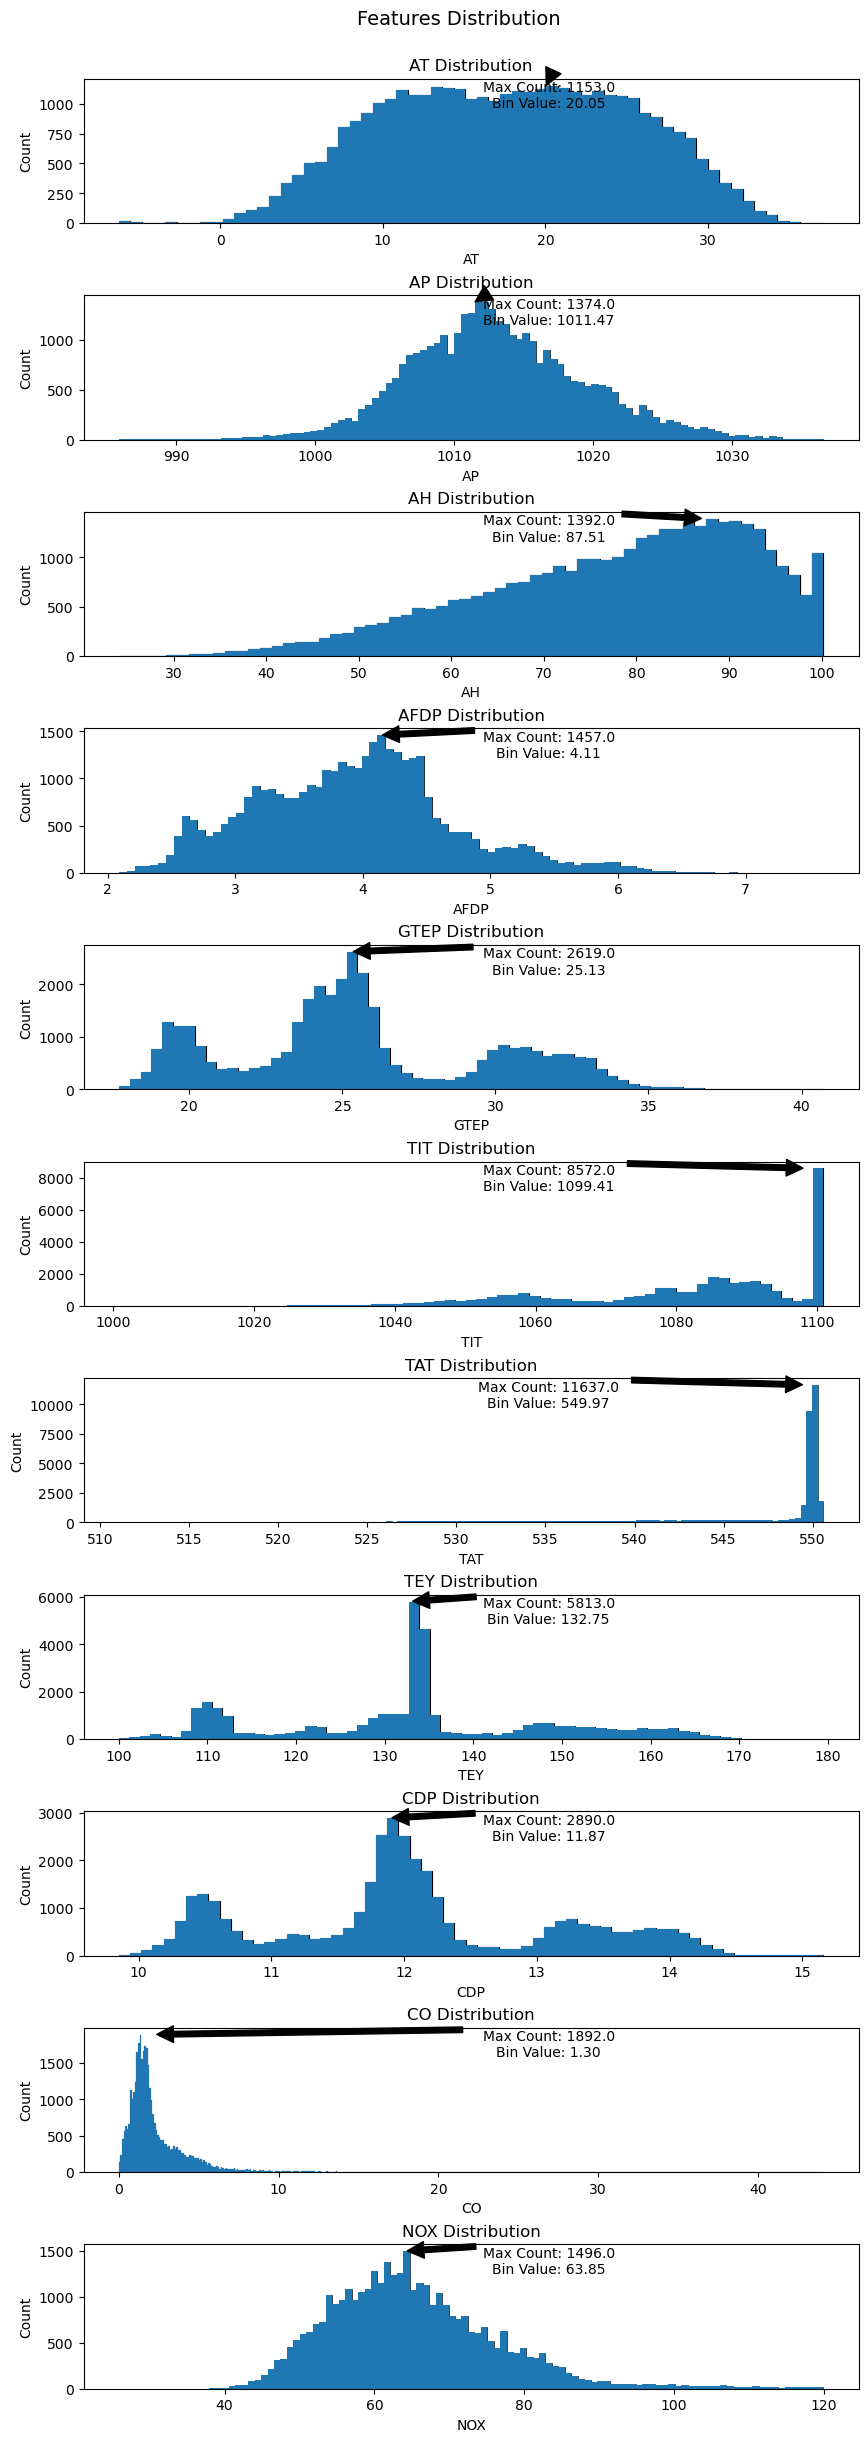

In [60]:
fig, axes = plt.subplots(len(cols), 1, figsize=(10, 30))

for i, col in enumerate(cols):
    sns.histplot(x=col, data=data, ax=axes[i])
    axes[i].set_ylabel("Count")
    axes[i].set_title(f"{col} Distribution")
    
    
    counts, bins, _ = axes[i].hist(data[col], bins='auto')
    max_count = np.max(counts)
    max_bin = bins[np.argmax(counts)]
    
   
    axes[i].annotate(f"Max Count: {max_count}\nBin Value: {max_bin:.2f}",
                     xy=(max_bin, max_count), xycoords='data',
                     xytext=(0.6, 0.8), textcoords='axes fraction',
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=10, color='black', ha='center')

fig.text(0.5, 0.9, "Features Distribution", va="center", ha="center", fontsize=14)
plt.subplots_adjust(hspace=0.5)
plt.show()

Feature Distribution Summary:
    
    AT- Max Count is 1153.0
    AP- Max Count is 1374.0
    AH- MAx Count is 1392.0
    AFDP- Max Count is 1457.0
    GTEP- Max Count is 2619.0
    TIT- Mx Count is 8572.0
    TAT- Max Count is 11637.0
    TEY- Max Count is 5813.0
    CDP- Max Count is 2890.0
    CO- Max Count is 1892.0
    NOX- Max Count is 1496.0


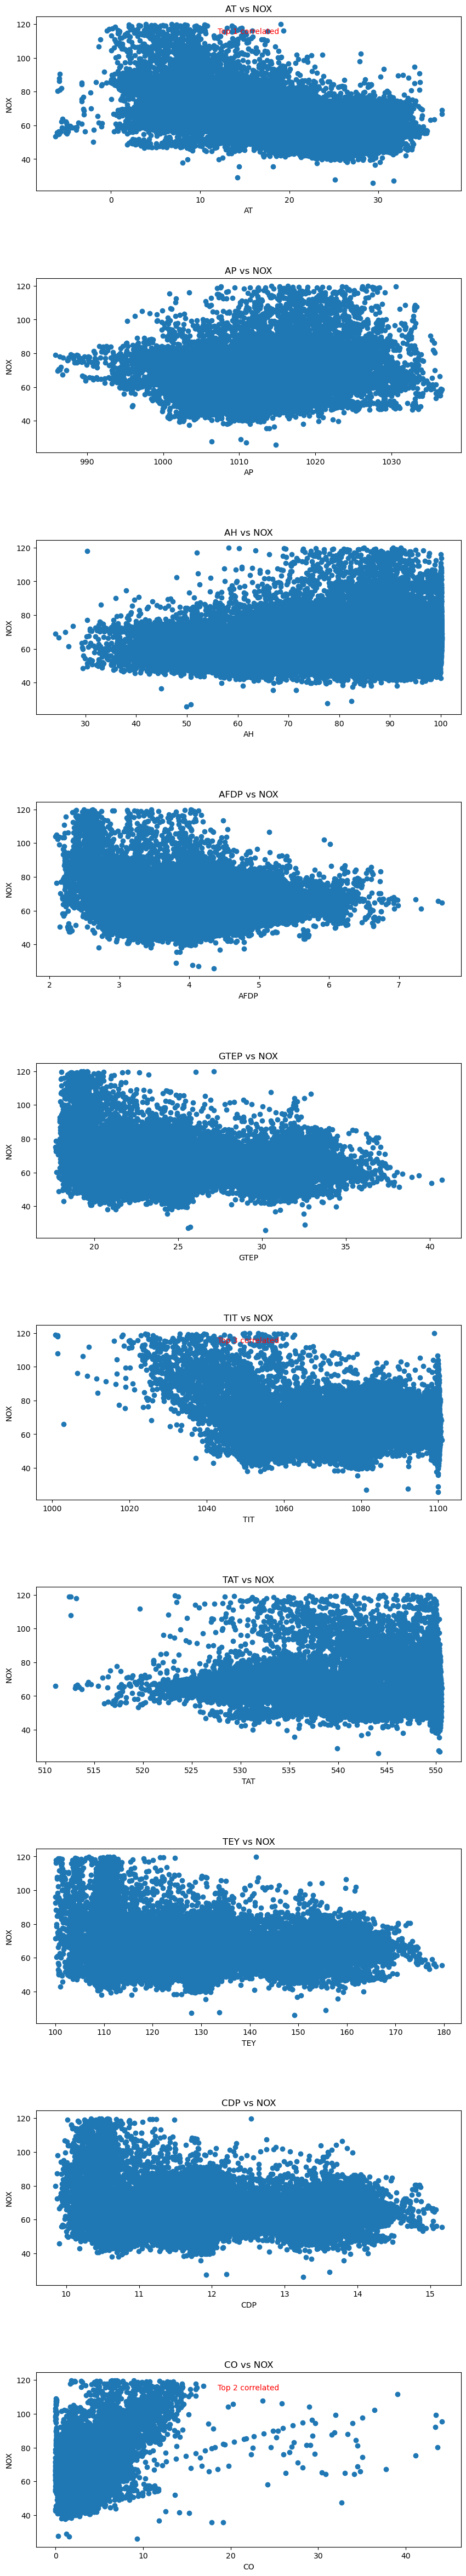

Top 3 features interacting the most with NOX: AT, CO, TIT


In [62]:
ig, axes = plt.subplots(len(cols) - 1, 1, figsize=(10, 6 * (len(cols) - 1)))


correlations = data[cols[:-1]].corrwith(data['NOX']).abs().sort_values(ascending=False)

top_features = correlations.index[:3]  
for i, col in enumerate(cols[:-1]):
    axes[i].scatter(data[col], data['NOX'])
    axes[i].set_ylabel("NOX")
    axes[i].set_xlabel(col)
    axes[i].set_title(f"{col} vs NOX")
    
    
    if col in top_features:
        idx = top_features.get_loc(col)
        axes[i].annotate(f"Top {idx + 1} correlated", xy=(0.5, 0.9), xycoords='axes fraction',
                         fontsize=10, color='red', ha='center')

fig.suptitle("Features Interaction with NOX", y=0.92, fontsize=14)
plt.subplots_adjust(hspace=0.5)
plt.show()

print(f"Top 3 features interacting the most with NOX: {', '.join(top_features)}")

Feature Intraction Summary:

From the above feature intraction analysis is is clear that Ambient temperature,Carbon monoxide emission and Turbine inlet temperature contributes more to increase in emission of nitrogen oxide by the Gas turbine.

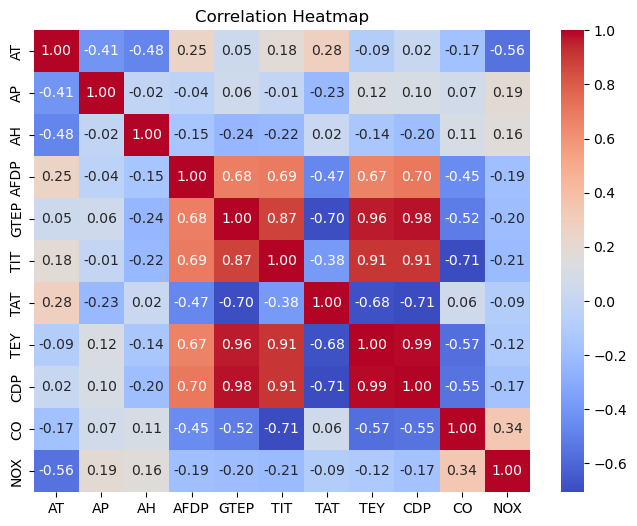

Most correlated variables: ('CDP', 'TEY') (Correlation: 0.99)
Least correlated variables: ('AP', 'TIT') (Correlation: 0.01)


In [63]:
correlation_matrix = data_ref.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


correlation_matrix_abs = correlation_matrix.abs().unstack().sort_values(ascending=False)
correlation_matrix_abs = correlation_matrix_abs[correlation_matrix_abs != 1.0]  
most_correlated = correlation_matrix_abs.idxmax()
least_correlated = correlation_matrix_abs.idxmin()

print(f"Most correlated variables: {most_correlated} (Correlation: {correlation_matrix_abs[most_correlated]:.2f})")
print(f"Least correlated variables: {least_correlated} (Correlation: {correlation_matrix_abs[least_correlated]:.2f})")


Correlation Analysis Summary:
    
    Compressor discharge pressure is directly influensing Turbine energy yield of a Gas Turbine
    Ambient pressure is directly influencing Turbine inlet temperature.

# Data Pre-Processing for Training and Prediction

In [29]:
x=data_ref.iloc[:,:-1]
print('Input Variables:')
x

Input Variables:


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747
...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340


In [30]:
y=data.iloc[:,-1]
print('Output variable:')
y

Output variable:


0         81.952
1         82.377
2         83.776
3         82.505
4         82.028
          ...   
36728     89.172
36729     88.849
36730     96.147
36731     64.738
36732    109.240
Name: NOX, Length: 36733, dtype: float64

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)
print('Training Variables:')
print('Input:')
print(x_train)
print('output:')
print(y_train)
print('\n')
print("Testing variables:")
print("Input:")
print(x_test)
print("Output:")
print(y_test)

Training Variables:
Input:
            AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY  \
10710  25.5810  1008.8  84.579  4.1100  25.636  1090.0  550.42  132.86   
2510   18.4010  1012.4  77.809  4.4260  31.534  1100.0  533.48  156.32   
35991  20.5990  1002.2  63.696  3.5426  24.089  1076.6  550.27  129.13   
3098   26.2460  1013.2  53.119  4.4381  30.841  1100.0  536.38  148.97   
2072   13.6380  1007.6  71.053  4.2477  23.485  1082.1  549.86  130.74   
...        ...     ...     ...     ...     ...     ...     ...     ...   
31019   7.7533  1011.8  73.067  2.6621  20.886  1039.7  545.41  109.27   
30280  10.7550  1017.4  66.106  4.0928  31.808  1099.9  537.88  157.61   
6637   10.3350  1029.3  68.066  5.1298  32.376  1098.6  527.65  160.46   
35343  15.8870  1007.2  86.328  3.2999  24.043  1076.1  550.25  130.07   
23720  14.2690  1014.5  98.499  3.9850  25.446  1087.7  550.02  134.18   

          CDP       CO  
10710  12.156  1.71190  
2510   13.652  0.41752  
35991  11

# Traning and Validating models

In [45]:
models=[XGBRegressor(),RandomForestRegressor(),lgb.LGBMRegressor()]
r2_scores=[]
print("Model Trainging:\n")
for model in models:
    print(f"Model used: {model}.")
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    r2=round(r2_score(y_test, y_pred),4)
    print(f"Accuracy Acquired: {r2}.")
    r2_scores.append(r2)
    print()
max_r2=max(r2_scores)
print(f"Best R2 Score Recorded: {max_r2}.")
max_idx=r2_scores.index(max_r2)
best_model=models[max_idx]
print()
print(f"Best Model Perfomance: {best_model}.")

Model Trainging:

Model used: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...).
Accuracy Acquired: 0.8803.

Model used: RandomForestRegressor().
Accuracy Acquired: 0.8868.

Model used: LGBMRegressor().
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 secon

In [50]:
print("Evaluating Best Model:")
rf=RandomForestRegressor()
rf.fit(x_train,y_train)
y_pred=model.predict(x_test)
r2=round(r2_score(y_test,y_pred),4)
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
print(f"R2 Score: {r2}.")
print(f"Mean Squared Error: {mse}.")
print(f"Mean Absolute Error: {mae}.")

Evaluating Best Model:
R2 Score: 0.8557.
Mean Squared Error: 19.644844584445558.
Mean Absolute Error: 2.987845033079698.


In [53]:
print("Model Saved.")
joblib.dump(rf, 'randomforest_Trees_Regressor_Model.joblib')

Model Saved.


['randomforest_Trees_Regressor_Model.joblib']

In [56]:
model_paths=["randomforest_Trees_Regressor_Model.joblib"]
for path in model_paths:
    if os.path.exists(path):
        model_path=path
print(f"Model to be extracted from {model_path}.")

Model to be extracted from randomforest_Trees_Regressor_Model.joblib.


In [57]:
loaded_model=joblib.load(model_path)
print("Extracted Model:")
display(loaded_model)

Extracted Model:


RandomForestRegressor()

# Predictive Analytics

In [64]:
print("Enter the input details:")
AT=8.7533
AP=1033.8
AH=73.067
AFDP=5.6621
GTEP=21.886
TIT=1039.7
TAT=546.41
TEY=109.27
CDP=9.390
CO=8.06512
new_data=np.array([[AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO]])
print(*new_data)
NOX_pred=round(loaded_model.predict(new_data)[0],2)
print(f"Predicted Nitrous Oxides Emission Amount from the gas turbine: {NOX_pred}")

Enter the input details:
[   8.7533  1033.8       73.067      5.6621    21.886   1039.7
  546.41     109.27       9.39       8.06512]
Predicted Nitrous Oxides Emission Amount from the gas turbine: 79.47
